# Generate a Mesh for a specified Shape using Gmsh
In this tutorial we walk through the process of creating an unstructured boundary layer mesh for a
specified geometry.

We will make use of the `mesh_func` function that utilizes `Gmsh` to create a mesh with specified
properties.

First, we will walk through the creation of a mesh for a simple geometry with a single trailing edge
which requires only a single mesh fan. Then, we will look at more complicated geometries that
require more than one mesh fans for generate a good mesh.

To get started we perform some basic imports for modules and functions we will use throughout the
tutorial.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from cfd_utils.mesh_func import mesh_func

## Simple Mesh - Single Mesh Fan
In the simple mesh generation case we work with the NACA0012 airfoil which has a single trailing
edge at $(1, 0)$. This therefore requires only a single mesh fan.

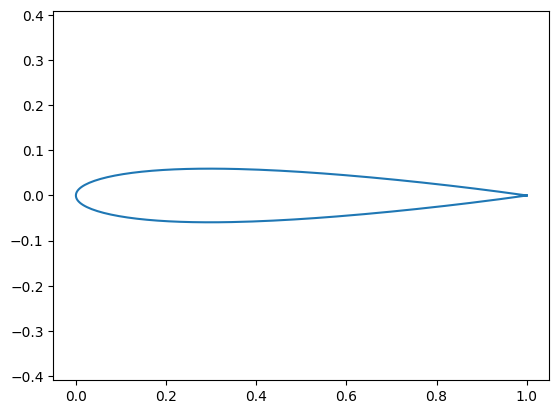

In [2]:
airfoil_name = 'n0012'
airfoil_coordinate_file_dir = Path('./airfoil_utils/airfoils')

# Get the geometry
airfoil_filename = airfoil_name + '.dat'
airfoil_coordinate_file_path = airfoil_coordinate_file_dir / airfoil_filename
X_simple = np.loadtxt(airfoil_coordinate_file_path)

# Visualize the geometry
plt.plot(X_simple[:, 0], X_simple[:, 1])
plt.axis('equal')
plt.show()

We now generate a mesh with some specified properties.

**_Note:_** In general mesh properties should come from the flow simulation that you wish to
perform. We use numbers that worked for a particular simulation we ran for another use case.

In [3]:
y_first_layer = 2.1323793321248807e-05
growth_ratio = 1.2
total_BL_thickness = 0.017468948584873578
mesh_size_at_airfoil = 0.0026494508027506214
mesh_size_at_farfield = 5.0
farfield_factor = 100
fan_points_coordinates_list = [(1.0, 0.0)]
fan_count = 15
visualize = True

In [4]:
mesh_details = mesh_func(
    X = X_simple,
    y_first_layer = y_first_layer,
    growth_ratio = growth_ratio,
    total_BL_thickness = total_BL_thickness,
    mesh_size_at_airfoil = mesh_size_at_airfoil,
    mesh_size_at_farfield = mesh_size_at_farfield,
    farfield_factor = farfield_factor,
    fan_points_coordinates_list = fan_points_coordinates_list,
    fan_count = fan_count,
    visualize = visualize
)

print(f'num_nodes: {mesh_details["num_nodes"]}, num_elements: {mesh_details["num_elements"]}')

num_nodes: 35347, num_elements: 46472


## Not So Simple Mesh - Multiple Mesh Fans
We now look at a more complicated geometry that we observed in an optimization procedure that
requires multiple mesh fans due to multiple sharp corners. This requires an automated way of
identifying points that require mesh fans based on some criteria.

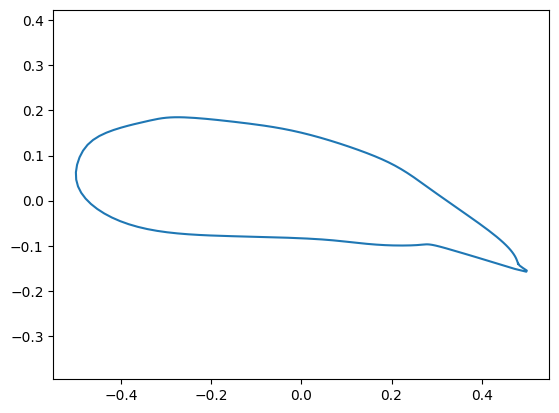

In [5]:
airfoil_name = 'multiple_sharp_corners'
airfoil_coordinate_file_dir = Path('./airfoil_utils/anomalous_airfoils')

# Get the geometry
airfoil_filename = airfoil_name + '.npy'
airfoil_coordinate_file_path = airfoil_coordinate_file_dir / airfoil_filename
X_notsimple = np.load(airfoil_coordinate_file_path)

# Visualize the geometry
plt.plot(X_notsimple[:, 0], X_notsimple[:, 1])
plt.axis('equal')
plt.show()

We now generate a mesh with the same specified properties as for the NACA0012 case. Now choose the
point with the largest $x$ coordinate as the trailing edge point where we put the fan mesh.

In [6]:
# Get trailing edge points to create a fan mesh there
fan_points_coordinates_list = []
fan_idx = np.where(X_notsimple[:, 0] == np.max(X_notsimple[:, 0]))[0]
fan_points = X_notsimple[fan_idx]
for point in fan_points:
    fan_points_coordinates_list.append((point[0].item(), point[1].item()))

In [7]:
mesh_details = mesh_func(
    X = X_notsimple,
    y_first_layer = y_first_layer,
    growth_ratio = growth_ratio,
    total_BL_thickness = total_BL_thickness,
    mesh_size_at_airfoil = mesh_size_at_airfoil,
    mesh_size_at_farfield = mesh_size_at_farfield,
    farfield_factor = farfield_factor,
    fan_points_coordinates_list = fan_points_coordinates_list,
    fan_count = fan_count,
    visualize = visualize
)

print(f'num_nodes: {mesh_details["num_nodes"]}, num_elements: {mesh_details["num_elements"]}')

num_nodes: 38522, num_elements: 50677


On zooming into the region near the trailing edge, we observe that the mesh at the other point with
an obvious sharp turn is quite sparse and we need another mesh fan there.

### Plotting the Distribution of Angles between Panels
To automatically determine points where we need mesh fans we use the angle between consecutive
panels on the shape. We set a threshold on the angle above which that point will have an associated
mesh fan in the boundary layer mesh.

First, for the NACA0012 airfoil and the above geometry we calculate the angle between consecutive
panels and plot the distribution using a histogram.

In [8]:
def angles_between_panels(X):
    # Find panel vectors
    v = X[1:, :] - X[:-1, :]
    # Restack first panel at the end to also compute the angle between the first and last panel
    v = np.vstack([v, v[0]])

    # Find angle between consecutive panel vectors using dot products
    v1 = v[:-1]
    v2 = v[1:]
    dot_prod = np.sum(v1 * v2, axis = 1)
    norm_prod = np.linalg.norm(v1, axis = 1) * np.linalg.norm(v2, axis = 1)
    angles = np.degrees(np.arccos(dot_prod / norm_prod))

    return angles

Largest 5 angles: [  9.47125517  10.03833415  10.03853308  10.21141283 164.06120424]


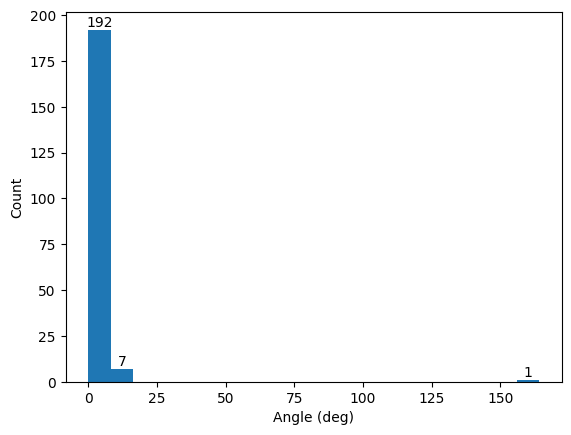

In [9]:
angles = angles_between_panels(X_simple)
print(f'Largest 5 angles: {np.sort(angles)[-5:]}')

values, bins, bars = plt.hist(angles, bins = 20)
plt.bar_label(bars, labels = [int(v) if v > 0 else '' for v in bars.datavalues])
plt.ylabel('Count')
plt.xlabel('Angle (deg)')
plt.show()

Largest 5 angles: [12.49547  14.334003 16.633375 79.97667  80.05872 ]


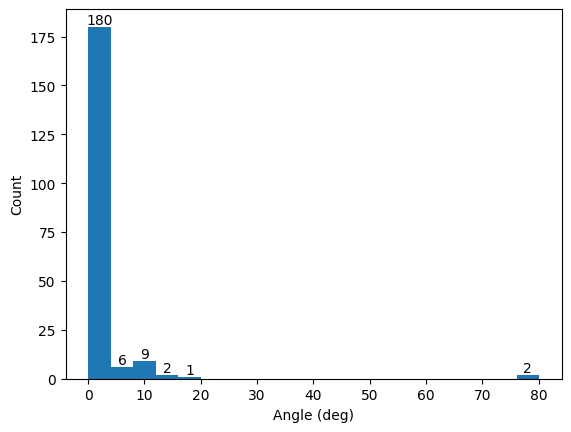

In [10]:
angles = angles_between_panels(X_notsimple)
print(f'Largest 5 angles: {np.sort(angles)[-5:]}')

values, bins, bars = plt.hist(angles, bins = 20)
plt.bar_label(bars, labels = [int(v) if v > 0 else '' for v in bars.datavalues])
plt.ylabel('Count')
plt.xlabel('Angle (deg)')
plt.show()

### Using Threshold on Angles between Panels as a Fan Mesh Criteria
We now decide the list of fan mesh points using a threshold on the angle between consecutive panels.
The points where the panel angle exceeds a pre-specified threshold (here $25\degree$) we place a fan
mesh.

In [11]:
def get_fan_points(X, threshold_angle):
    angles = angles_between_panels(X)

    # Get the points corresponding to angles greater than specified threshold
    idx = np.where(angles > threshold_angle)[0]
    N = X.shape[0]
    # Add 1 to the indices as the angle index 0 corresponds to the angle at point index 1
    fan_points_idx = idx + 1

    fan_points_coordinates_list = [tuple(row) for row in X[fan_points_idx].tolist()]

    return fan_points_coordinates_list

In [12]:
fan_points_coordinates_list = get_fan_points(X = X_simple, threshold_angle = 25)

mesh_details = mesh_func(
    X = X_simple,
    y_first_layer = y_first_layer,
    growth_ratio = growth_ratio,
    total_BL_thickness = total_BL_thickness,
    mesh_size_at_airfoil = mesh_size_at_airfoil,
    mesh_size_at_farfield = mesh_size_at_farfield,
    farfield_factor = farfield_factor,
    fan_points_coordinates_list = fan_points_coordinates_list,
    fan_count = fan_count,
    visualize = visualize
)

print(f'num_nodes: {mesh_details["num_nodes"]}, num_elements: {mesh_details["num_elements"]}')

num_nodes: 35346, num_elements: 46470


In [13]:
fan_points_coordinates_list = get_fan_points(X = X_notsimple, threshold_angle = 25)

mesh_details = mesh_func(
    X = X_notsimple,
    y_first_layer = y_first_layer,
    growth_ratio = growth_ratio,
    total_BL_thickness = total_BL_thickness,
    mesh_size_at_airfoil = mesh_size_at_airfoil,
    mesh_size_at_farfield = mesh_size_at_farfield,
    farfield_factor = farfield_factor,
    fan_points_coordinates_list = fan_points_coordinates_list,
    fan_count = fan_count,
    visualize = visualize
)

print(f'num_nodes: {mesh_details["num_nodes"]}, num_elements: {mesh_details["num_elements"]}')

num_nodes: 40014, num_elements: 53445
